# Elasticity equation

In this tutorial we present how to solve the elasticity equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unknown is the displacement $u$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$\lambda$ Lamé constant and $\mu$ the Kirchhoff modulus, we want to solve the following problem: find $u$ such that
$$
\nabla \cdot [ 2 \mu \epsilon(u) + \lambda \nabla \cdot u I] = -b
$$
with $\epsilon$ the symmetric gradient and $b$ a body force, which is set to $0$ in this example.
For this test case we set the following boundary conditions related to the so-called footstep problem:
$$ u = 0 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot \sigma = [0, 0]^\top \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \qquad \nu \cdot \sigma = [0, -1e-3]^\top \text{ on } \partial_{top} \Omega$$
where $\sigma = 2 \mu \epsilon(u) + \lambda \nabla \cdot u I$ is the stess tensor.

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [19]:
import os
import numpy as np

import pyvista as pv

import porepy as pp
import pygeon as pg

We create now the grid, since we use a vector Lagrangian of order 1 for ${u}$ we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 3d.

In [20]:
mesh_size = 0.1
dim = 2

sd = pg.unit_grid(dim, mesh_size, as_mdg=False)
sd.compute_geometry()

With the following code we set the data, in particular the Lamé and the Kirchhoff modulus, and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [21]:
key = "elasticity"
data = {pp.PARAMETERS: {key: {"lambda": 1, "mu": 0.5}}}

bottom = np.hstack([np.isclose(sd.nodes[1, :], 0)] * 2)
top = np.isclose(sd.face_centers[1, :], 1)

fun = lambda _: np.array([0, -1e-3])

Once the data are assigned to the grid, we construct the matrices. Once the latter is created, we also construct the right-hand side containing the boundary conditions.

In [22]:
vec_p1 = pg.VecLagrange1(key)

A = vec_p1.assemble_stiff_matrix(sd, data)
b = vec_p1.assemble_nat_bc(sd, fun, top)

We need to solve the linear system, PyGeoN provides a framework for that. The actual imposition of essential boundary conditions (displacement boundary conditions) might change the symmetry of the global system, the class `pg.LinearSystem` preserves this structure by internally eliminating these degrees of freedom.

In [23]:
ls = pg.LinearSystem(A, b)
ls.flag_ess_bc(bottom, np.zeros(vec_p1.ndof(sd)))
u = ls.solve()

Compute now the stress tensor, one `sd.dim` x `sd.dim` tensor per cell.

In [24]:
cell_sigma = vec_p1.compute_stress(sd, u, data)
# split the tensor in each component
cell_sigma_xx = cell_sigma[:, 0, 0]
cell_sigma_xy = cell_sigma[:, 0, 1]
cell_sigma_yy = cell_sigma[:, 1, 1]

We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [ ]:
# reshape the displacement for the export
u = np.reshape(u, (sd.dim, -1))
u = np.vstack((u, np.zeros(sd.num_nodes)))

# export the solution
folder_name = os.path.join(os.getcwd(), key)
file_name = "sol"

save = pp.Exporter(sd, file_name, folder_name=folder_name)
save.write_vtu(
    [
        ("cell_sigma_xx", cell_sigma_xx),
        ("cell_sigma_xy", cell_sigma_xy),
        ("cell_sigma_yy", cell_sigma_yy),
    ],
    data_pt=[("u", u)],
)

A representation of the computed solution is given below.

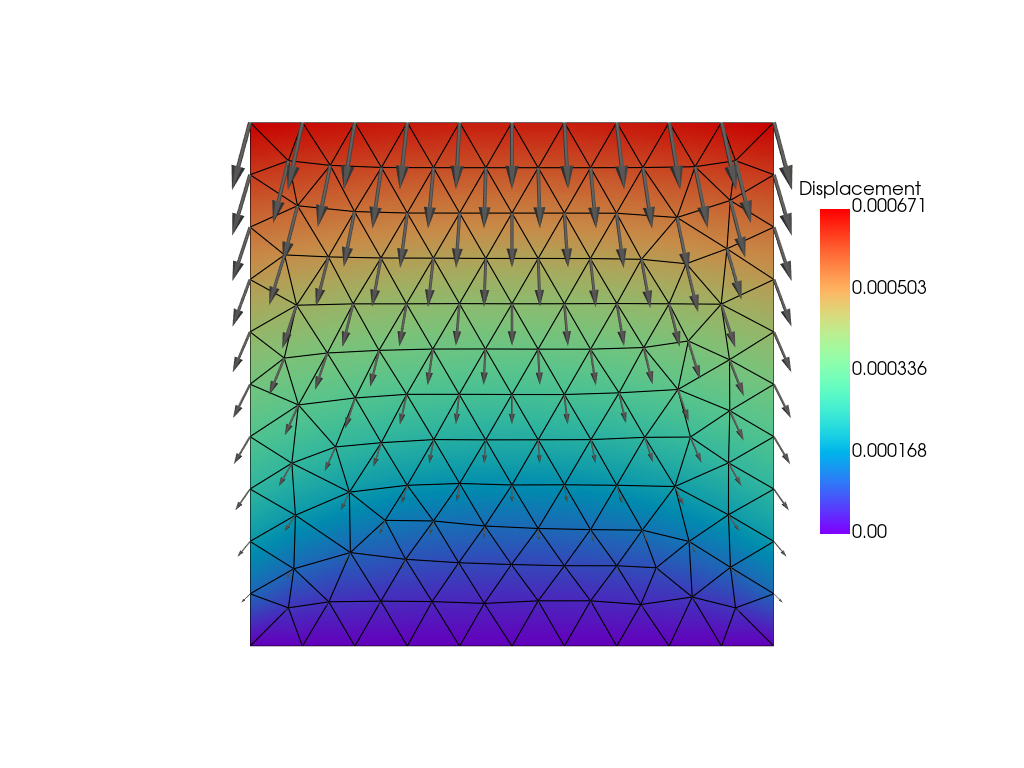

In [28]:
file_vtu = os.path.join(folder_name, file_name + "_2.vtu")
mesh = pv.read(file_vtu)

plotter = pv.Plotter(off_screen=True, notebook=True)

# Glyphs scaled by magnitude
arrows = mesh.glyph(orient="u", scale="u", factor=200)
plotter.add_mesh(arrows, color="gray")

# Mesh colored by displacement magnitude
bar = {"title": "Displacement", "vertical": True, "position_x": 0.8, "position_y": 0.3}
plotter.add_mesh(
    mesh, scalars="u", cmap="rainbow", show_edges=True, scalar_bar_args=bar
)

# Show the result
plotter.view_xy()
plotter.enable_parallel_projection()
plotter.show(jupyter_backend="static")


In [ ]:
# Consistency check
assert np.isclose(np.linalg.norm(u), 0.004558079528343269)
assert np.isclose(np.linalg.norm(cell_sigma), 0.01583974908807611)